In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, List
from tqdm import tqdm

from egttools.games import AbstractNPlayerGame
from egttools import sample_simplex, calculate_nb_states
from egttools.numerical import PairwiseComparisonNumerical
from egttools.analytical import PairwiseComparison
from egttools.utils import calculate_stationary_distribution
from egttools.plotting import draw_invasion_diagram

In [2]:
class PGGWithCommitment(AbstractNPlayerGame):
    def __init__(self, 
                  group_size: int,   # number of participants in the PGG
                  c: float,          # cost of cooperation
                  r: float,          # enhancing factor (multiplier)
                  eps: float,        # cost for propose a commitment
                  delta : float,     # cost to don't respect the commitment
                  ):
          
        # Initialize superclass
        AbstractNPlayerGame.__init__(self, 9, group_size)
        
        # Parameters and configurations
        self.nb_strategies_ = 9
        self.group_size_ = group_size
        self.strategies = ["COMP1", "COMP2", "COMP3", "COMP4", "COMP5", "C", "D", "FAKE", "FREE"]

        self.c = c
        self.r = r
        self.eps = eps
        self.delta = delta
        self.nb_group_configurations_ = self.nb_group_configurations()  # Calculate number of possible group configurations
        self.calculate_payoffs()    # Calculate payoffs for each strategy in different group configurations

    def play(self, group_composition: Union[List[int], np.ndarray], game_payoffs: np.ndarray) -> None:
        # Initialize payoffs for each strategy in the group
        game_payoffs[:] = 0.
        COMP1, COMP2, COMP3, COMP4, COMP5, COOPERATOR, DEFECTOR, FAKER, FREE  = 0, 1, 2, 3, 4, 5, 6, 7, 8

        # Calculate the number of each type of player in the group
        nb_commitment = group_composition[COMP1] + group_composition[COMP2] + group_composition[COMP3] + group_composition[COMP4] + group_composition[COMP5]  # number of commitment
        
        if(nb_commitment==0):  # If no one propose, we don't have a FREE player -->  Classical PGG
            nb_contributors = group_composition[COOPERATOR]
        else: #If one propose, we have can have a FREE player
            nb_contributors = nb_commitment + group_composition[COOPERATOR] + group_composition[FREE]  # number of contributors
        
        nb_fake = group_composition[FAKER]  # number of fake
        nb_accept = group_composition[FAKER] + nb_contributors

        # Calculate the total contribution and reward for the group
        total_contribution = self.c * (nb_contributors)
        total_reward = self.r * total_contribution
        individual_reward = total_reward / (self.group_size_)

        # Find F
        F = int(0)
        comp = int(0)
        for i in group_composition[:5]:
          comp+=1
          if(i>0):
            F=comp

        if F <= nb_accept or nb_commitment==0: #le nombre de gens qui acceptent le contrat doit être plus grand que F
        #ou le nombre de COMP est égal à 0 et on joue juste un PGG classique
          for index, strategy_count in enumerate(group_composition):
              if strategy_count > 0:  # (else: it's not in the group, its payoff is 0)
                game_payoffs[index] += individual_reward
                if "COMP" in self.strategies[index]:
                  game_payoffs[index] -=  (self.c + (self.eps/nb_commitment)- ((nb_fake*self.delta)/nb_commitment))
                elif self.strategies[index] == "C":
                  game_payoffs[index] -=  self.c
                if(nb_commitment > 0):
                  if self.strategies[index] == "FAKE":
                    game_payoffs[index] -= self.delta
                  elif self.strategies[index] == "FREE":
                      game_payoffs[index] -= self.c

    def calculate_payoffs(self) -> np.ndarray:
        """Calculate and store the payoffs for each strategy in the game."""
        
        # Initialize an array to store payoffs for each configuration
        payoffs_container = np.zeros(shape=(self.nb_strategies_,), dtype=np.float64)
        
        # Loop over all possible group configurations
        for i in range(self.nb_group_configurations_):
            # Generate a sample group composition
            group_composition = sample_simplex(i, self.group_size_, self.nb_strategies_)
            group_composition = np.array(group_composition, dtype=float)

            # Play the game with the given group composition
            self.play(group_composition, payoffs_container)

            # Update the payoff for each strategy based on this configuration
            for strategy_index, strategy_payoff in enumerate(payoffs_container):
                self.update_payoff(strategy_index, i, strategy_payoff)
                
            # Reset the payoff container for the next configuration
            payoffs_container[:] = 0

        return self.payoffs()


In [16]:
group_size = 5
c = 1.3
Z = 100  # Population size
beta = 0.25  # Selection intensity
r_c = 2.5
nb_points = 6
eps_values = np.linspace(0., 2., nb_points)
delta_values = np.linspace(0., 6., nb_points)

optimal_F_r25 = np.zeros((nb_points, nb_points), dtype = float)

for i, eps in enumerate(eps_values):
    for j, delta in enumerate(delta_values):
        optimal_F = np.zeros((5,), dtype = float)
        game = PGGWithCommitment(group_size, c, r_c, eps, delta)
        evolver = PairwiseComparison(Z, game)
        transition_matrix, _ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
        stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
        optimal_F_r25[i, j] = np.argmax(stationary_distribution[0:5]) +1
        #print(optimal_F_r25)
print(optimal_F_r25)

[[4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4.]
 [4. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5.]]


In [5]:
print(optimal_F_r25)

[[4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4.]
 [4. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5.]]


In [17]:
group_size = 5
c = 1.2539
Z = 100  # Population size
beta = 0.25  # Selection intensity
r_c = 4.0
nb_points = 6
eps_values = np.linspace(0., 2., nb_points)
delta_values = np.linspace(0., 6., nb_points)

optimal_F_r40 = np.zeros((nb_points, nb_points), dtype = float)

for i, eps in enumerate(eps_values):
    for j, delta in enumerate(delta_values):
        optimal_F = np.zeros((5,), dtype = float)
        game = PGGWithCommitment(group_size, c, r_c, eps, delta)
        evolver = PairwiseComparison(Z, game)
        transition_matrix, _ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
        stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
        optimal_F_r40[i, j] = np.argmax(stationary_distribution[0:5]) +1
print(optimal_F_r40)

[[3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3.]
 [4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4.]]


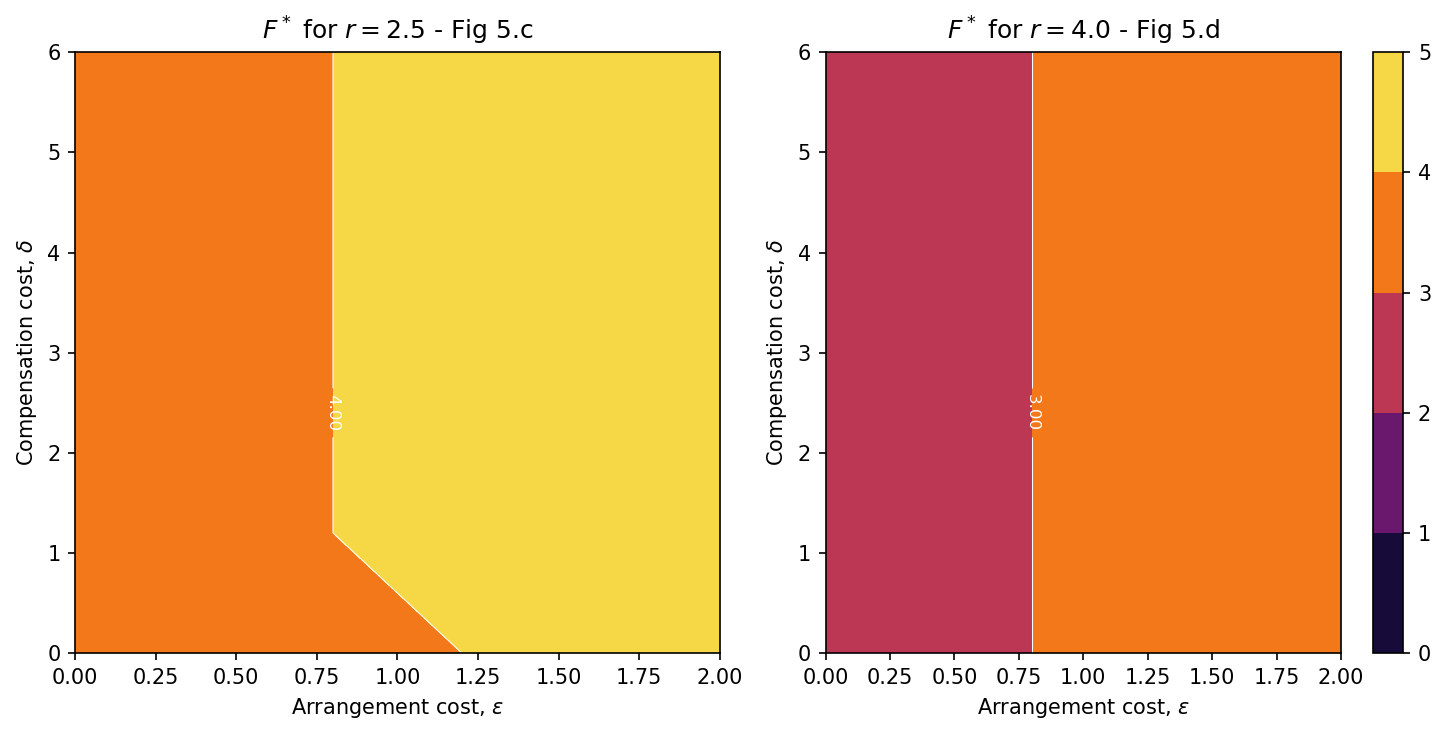

In [18]:
# Define the contour levels between 0 and 1
levels = np.linspace(0., 5., 6)

plt.figure(figsize=(10, 5), dpi=150)

# First graph: Avoidance frequency of cooperation
plt.subplot(1, 2, 1)
contour = plt.contourf(eps_values, delta_values, optimal_F_r25.T, levels=levels, cmap='inferno')
#plt.colorbar(orientation='vertical')
contour_lines = plt.contour(eps_values, delta_values, optimal_F_r25.T, levels=levels, colors='white', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt="%.2f")  
plt.xlabel(r'Arrangement cost, $\epsilon$')
plt.ylabel(r'Compensation cost, $\delta$')
plt.title(r'$F^*$ for $r = 2.5$ - Fig 5.c')


# Second graph: Avoidance frequency of commitment
plt.subplot(1, 2, 2)
contour = plt.contourf(eps_values, delta_values, optimal_F_r40.T, levels=levels, cmap='inferno')
plt.colorbar(orientation='vertical')
contour_lines = plt.contour(eps_values, delta_values, optimal_F_r40.T, levels=levels, colors='white', linewidths=0.5)
plt.clabel(contour_lines, fontsize=8, fmt="%.2f") 
plt.xlabel(r'Arrangement cost, $\epsilon$')
plt.ylabel(r'Compensation cost, $\delta$')
plt.title(r'$F^*$ for $r = 4.0$ - Fig 5.d')


plt.tight_layout()
plt.show()